# PiML Model Interpretability

- Data Pipeline

- Binning Logistic and XGB1

- XGBoost Benign Overfitting

- Post-hoc Explainability

- Inherently Interpretable Benchmark Models
  - XGB2 and GAMI-Net
  - Inherent Interpretability
  - Monotonic Constraints



In [ ]:
!pip install piml

In [3]:
from piml import Experiment
exp = Experiment()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 1) Data Pipeline

In [4]:
# Choose SimuCredit
exp.data_loader()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [5]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [6]:
# remove "Gender" and "Race" (Categorical)
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [59]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 2) Binning Logistic and XGB1

In [60]:
# Binning Logistic Regression
from sklearn.pipeline import Pipeline
from optbinning import BinningProcess
from sklearn.linear_model import LogisticRegression

feature_names = exp.get_feature_names()
target_name = exp.get_target_name()
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

lr = Pipeline(steps=[('Step 1', BinningProcess(feature_names)),
                     ('Step 2', LogisticRegression())])

lr.fit(train_x, train_y.ravel())

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Pipeline(steps=[('Step 1',
                 BinningProcess(variable_names=['Mortgage', 'Balance',
                                                'Amount Past Due',
                                                'Credit Inquiry', 'Open Trade',
                                                'Delinquency',
                                                'Utilization'])),
                ('Step 2', LogisticRegression())])

In [61]:
# Register it as PiML pipeline
tmp = exp.make_pipeline(model=lr)
exp.register(tmp, "BinningLogistic")
exp.model_diagnose(model="BinningLogistic", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.6787,0.7374,0.6923,0.6000,0.2065
Test,0.6760,0.7341,0.6929,0.6036,0.2078
Gap,-0.0027,-0.0034,0.0006,0.0035,0.0013


In [62]:
# XGBoost of Depth 1
from piml.models import XGB1Classifier

exp.model_train(XGB1Classifier(), name='XGB1')
exp.model_diagnose(model="XGB1", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.6901,0.7502,0.7067,0.5895,0.2020
Test,0.6875,0.7458,0.7075,0.5944,0.2038
Gap,-0.0026,-0.0043,0.0009,0.0050,0.0018


## 3) XGBoost Benign Overfitting

In [63]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.01, n_estimators=1000, random_state=0)
model.fit(train_x, train_y)

pipeline = exp.make_pipeline(model=model,
                             task_type="classification",
                             train_x=train_x,
                             train_y=train_y,
                             test_x=test_x,
                             test_y=test_y,
                             feature_names=feature_names,
                             target_name=target_name)
exp.register(pipeline, "XGB-default")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [64]:
exp.model_diagnose(model="XGB-default", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7428,0.8236,0.7635,0.5161,0.1721
Test,0.6857,0.7492,0.7139,0.5932,0.2028
Gap,-0.0570,-0.0744,-0.0496,0.0771,0.0306


In [65]:
# Hyperparameter Tuning with Grid Search
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}
result = exp.model_tune(model="XGB-default",
                        method="grid",
                        parameters=parameters,
                        metric=['AUC', 'LogLoss'],
                        test_ratio=0.4,
                        random_state=0)
result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Rank(by AUC),AUC,LogLoss,time
params,,,,
{'max_depth': 3},1,0.743664,0.597077,0.789103
{'max_depth': 2},2,0.743436,0.596416,0.667802
{'max_depth': 4},3,0.742848,0.599094,1.006239
{'max_depth': 5},4,0.738847,0.603890,1.339736
{'max_depth': 6},5,0.735393,0.611204,3.550225
{'max_depth': 7},6,0.731611,0.617371,2.213889
{'max_depth': 8},7,0.727245,0.626900,2.764489
{'max_depth': 1},8,0.722967,0.613316,0.547421


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

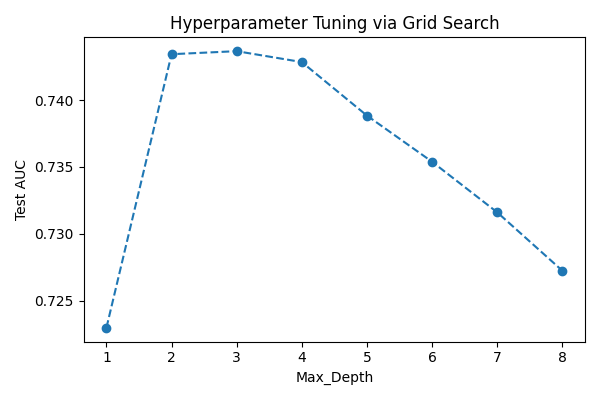

In [66]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 1+result.data.shape[0]), result.cv_results_["mean_test_AUC"], '--o')
plt.xlabel("Max_Depth")
plt.ylabel("Test AUC")
plt.title("Hyperparameter Tuning via Grid Search")
plt.show()

In [67]:
import scipy
parameter_space = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                   'n_estimators': scipy.stats.randint(100, 2000),
                   'learning_rate': scipy.stats.loguniform(0.001, 1.0)}
result = exp.model_tune(model="XGB-default",
                        method="randomized",
                        parameters=parameter_space,
                        metric=["AUC", "LogLoss"],
                        n_runs=100,
                        test_ratio=0.4,
                        random_state=0)
# result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

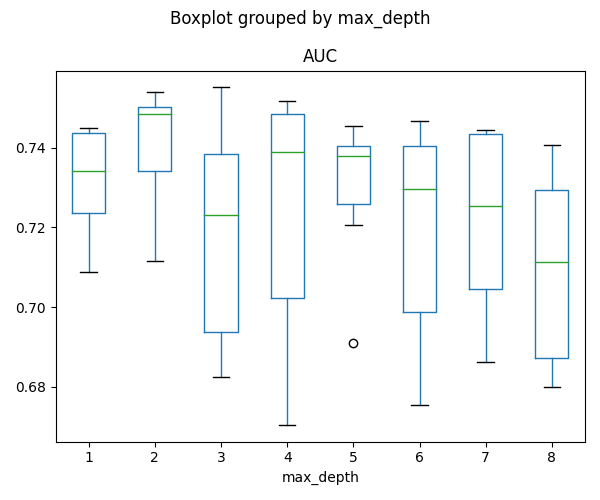

In [68]:
import pandas as pd
df = pd.concat([pd.DataFrame(result.cv_results_['params']),
                pd.DataFrame(result.cv_results_["mean_test_AUC"], columns=["AUC"]),
                pd.DataFrame(result.cv_results_["mean_test_LogLoss"], columns=["LogLoss"])], axis=1)
df.boxplot(column=['AUC'], by='max_depth', grid=False, figsize=(6, 5))
plt.show()

In [69]:
params = result.get_params_ranks(rank=1)
params

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

{'learning_rate': 0.00918315096980776, 'max_depth': 3, 'n_estimators': 1107}

In [70]:
exp.model_train(XGBClassifier(**params), name="XGB-HPO")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [71]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score

def score(model, iteration_range):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x, iteration_range=iteration_range)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x, iteration_range=iteration_range)[:, 1])
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'n_iteration': iteration_range[1], 'train_auc': train_auc, 'test_auc': test_auc}

all_metrics = []
model = exp.get_model("XGB-HPO").estimator
xgbinfo = model.get_booster().trees_to_dataframe()
for i in range(0, model.get_num_boosting_rounds(), 5):
    metrics = score(model, (0, i + 1))
    all_metrics.append(metrics)
all_resluts = pd.DataFrame(all_metrics)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

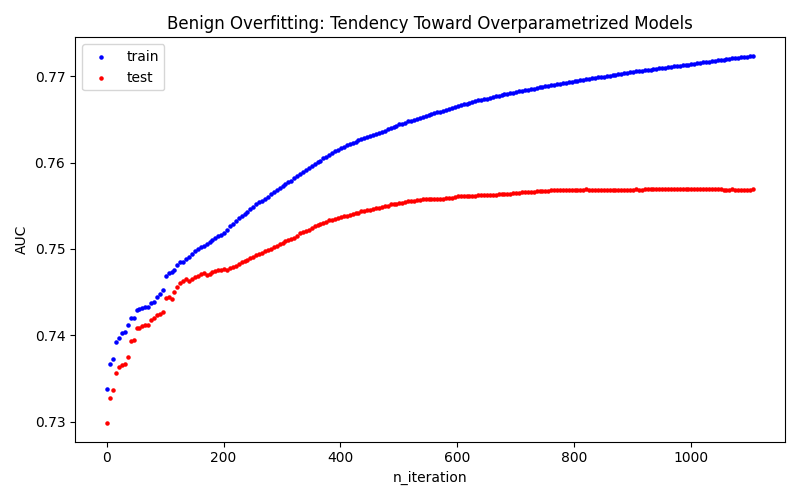

In [72]:
plt.figure(figsize=(8,5))
plt.scatter(all_resluts["n_iteration"], all_resluts["train_auc"], label="train", color="blue", s=5)
plt.scatter(all_resluts["n_iteration"], all_resluts["test_auc"], label="test", color="red",  s=5)
plt.legend()
plt.ylabel("AUC")
plt.xlabel("n_iteration")
plt.title("Benign Overfitting: Tendency Toward Overparametrized Models")
plt.show()

## 4) Post-hoc Explainability

In [73]:
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 5) Inherently Interpretable Benchmark Models


### GAM, XGB1, XGB2, GAMI-Net

In [74]:
# Choose Models: GAM, XGB2, GAMI-Net (default config)
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

### Inherent Interpretability

In [75]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

### Monotonic Constraints

In [76]:
# Choose Model: XGB1-Mono, XGB2-Mono
# Feature_increasing =  "Mortgage", "Balance"
# Feature_decreasing =  "Utilization", "Delinquency", "Credit Inquiry", "Open Trade", "Amount Past Due"
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [78]:
# Choose XGB2-Moto
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [79]:
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…